<a href="https://colab.research.google.com/github/leonfuns/Data-Logistic-Elastic-Net-Regression-RANDOM-FOREST/blob/main/data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary packages for data analysis and visualization
#install.packages(c("tidyverse","ggpubr","moments","scatterplot3d","factoextra","ranger"))
#install.packages(c("tidyverse","caret","ranger","ggpubr","rpart","rpart.plot"))
install.packages("tidyverse")
install.packages("caret")
install.packages("ranger")
install.packages("ggpubr")
install.packages("rpart")
install.packages("rpart.plot")
install.packages("glmnet")

#install.packages(c("rpart","rpart.plot"))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘Rcpp’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘RcppEigen’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘corrplot’, ‘car’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is

In [ ]:
# Load required libraries
library(tidyverse)
library(ggpubr)
# library(moments)
# library(scatterplot3d)
# library(factoextra)
library(ranger)  #For random forest
library(caret)  #Classification and Regression Training package

library(rpart)
library(rpart.plot)

# Set the working directory
# Note that you may need to change the path to your work directory
#getwd()
#setwd("/Users/leonfuns/Projects/ECU/data-analysis/a2.try")
options(scipen = 999)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()   masks base::%||%()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




In [ ]:
mydata.b.train <- read.csv("mydata.b.train.csv")
mydata.ub.train <- read.csv("mydata.ub.train.csv")
mydata.test <- read.csv("mydata.test.csv")

In [ ]:
mydata = read.csv("HealthCareData_2024.csv", stringsAsFactors = TRUE)
dim(mydata)
# ```

## ------------------------------------------------------------------
#        Part 1 – General data preparation and cleaning (b)
## ------------------------------------------------------------------
# ```{r}
## i. Clean the dataset based on the feedback received for Assignment 1.
summary(mydata)

mydata$AlertCategory = fct_collapse(mydata$AlertCategory,
  Informational = c("Informational", "Info"))
mydata$NetworkEventType = fct_collapse(mydata$NetworkEventType,
  PolicyViolation = c("Policy_Violation", "PolicyViolation"))

mydata$NetworkAccessFrequency[mydata$NetworkAccessFrequency == -1] = NA

mydata$ResponseTime[mydata$ResponseTime > 150 ] = NA

summary(mydata)
# ```

# ```{r}
## ii. merge the ‘Regular’ and ‘Unknown’ categories together.
mydata$NetworkInteractionType = fct_collapse(mydata$NetworkInteractionType,
                                  Others = c("Regular", "Unknown"))

summary(mydata)
# ```

# ```{r}
## iii. Standardising dataset.
# Delete the System Access Rate as this column have too many NA data and it will affect
dat.cleaned = na.omit(mydata[,-9]);dat.cleaned
summary(dat.cleaned)
# ```

## ------------------------------------------------------------------
#        Part 1 – General data preparation and cleaning (c)
## ------------------------------------------------------------------
# ```{r}
# Separate samples of normal and malicious events
dat.class0 = dat.cleaned %>% filter(Classification == "Normal") # normal
dat.class1 = dat.cleaned %>% filter(Classification == "Malicious") # malicious
# Randomly select 9600 non-malicious and 400 malicious samples using your student
# ID, then combine them to form a working data set
set.seed(10582390)
rows.train0 = sample(1:nrow(dat.class0), size = 9600, replace = FALSE)
rows.train1 = sample(1:nrow(dat.class1), size = 400, replace = FALSE)
# Your 10000 ‘unbalanced’ training samples
train.class0 = dat.class0[rows.train0,] # Non-malicious samples
train.class1 = dat.class1[rows.train1,] # Malicious samples
mydata.ub.train = rbind(train.class0, train.class1)
# Your 19200 ‘balanced’ training samples, i.e. 9600 normal and malicious samples each.
set.seed(10582390)
train.class1_2 = train.class1[sample(1:nrow(train.class1), size = 9600,
  replace = TRUE),]
mydata.b.train = rbind(train.class0, train.class1_2)
# Your testing samples
test.class0 = dat.class0[-rows.train0,]
test.class1 = dat.class1[-rows.train1,]
mydata.test = rbind(test.class0, test.class1)
# ```

## ------------------------------------------------------------------
#   Part 2 – Compare the performances of different ML algorithms (a)
## ------------------------------------------------------------------
# ```{r}
set.seed(10582390)
models.list1 = c("Logistic Ridge Regression",
  "Logistic LASSO Regression",
  "Logistic Elastic-Net Regression")
models.list2 = c("Classification Tree",
  "Bagging Tree",
  "Random Forest")
myModels = c(sample(models.list1, size = 1),
  sample(models.list2, size = 1))
myModels %>% data.frame

[1] 568309     14

       AlertCategory            NetworkEventType  NetworkInteractionType
 Alert        : 33325   NormalOperation : 46268   Anomalous :247227     
 Info         :   568   Policy_Violation:170492   Critical  : 30381     
 Informational: 36991   PolicyViolation :327655   Elevated  : 33531     
                                                  Suspicious:256068     
                                                  Unknown   :   505     
                                                                        
 DataTransferVolume_IN DataTransferVolume_OUT TransactionsPerSession
 Min.   :  9437211     Min.   :     1024      Min.   : 1024         
 1st Qu.:126853092     1st Qu.:118164893      1st Qu.:27657         
 Median :130860714     Median :143576956      Median :32268         
 Mean   :132161199     Mean   :142800911      Mean   :32475         
 3rd Qu.:135091809     3rd Qu.:166956706      3rd Qu.:37102         
 Max.   :286793511     Max.   :300000000      Max.   :65535         
      

       AlertCategory           NetworkEventType  NetworkInteractionType
 Alert        : 33325   NormalOperation: 46268   Anomalous :247227     
 Informational: 37559   PolicyViolation:498147   Critical  : 30381     
                                                 Regular   :   597     
                                                 Suspicious:256068     
                                                 Unknown   :   505     
                                                                       
 DataTransferVolume_IN DataTransferVolume_OUT TransactionsPerSession
 Min.   :  9437211     Min.   :     1024      Min.   : 1024         
 1st Qu.:126853092     1st Qu.:118164893      1st Qu.:27657         
 Median :130860714     Median :143576956      Median :32268         
 Mean   :132161199     Mean   :142800911      Mean   :32475         
 3rd Qu.:135091809     3rd Qu.:166956706      3rd Qu.:37102         
 Max.   :286793511     Max.   :300000000      Max.   :65535         
             

       AlertCategory           NetworkEventType  NetworkInteractionType
 Alert        : 33325   NormalOperation: 46268   Anomalous :247227     
 Informational: 37559   PolicyViolation:498147   Critical  : 30381     
                                                 Others    :  1102     
                                                 Suspicious:256068     
                                                                       
                                                                       
 DataTransferVolume_IN DataTransferVolume_OUT TransactionsPerSession
 Min.   :  9437211     Min.   :     1024      Min.   : 1024         
 1st Qu.:126853092     1st Qu.:118164893      1st Qu.:27657         
 Median :130860714     Median :143576956      Median :32268         
 Mean   :132161199     Mean   :142800911      Mean   :32475         
 3rd Qu.:135091809     3rd Qu.:166956706      3rd Qu.:37102         
 Max.   :286793511     Max.   :300000000      Max.   :65535         
             

,AlertCategory,NetworkEventType,NetworkInteractionType,DataTransferVolume_IN,DataTransferVolume_OUT,TransactionsPerSession,NetworkAccessFrequency,UserActivityLevel,SessionIntegrityCheck,ResourceUtilizationFlag,SecurityRiskLevel,ResponseTime,Classification
,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<lgl>,<lgl>,<int>,<dbl>,<fct>
1,Warning,PolicyViolation,Anomalous,131262728,146592187,32537,22456,5,TRUE,FALSE,132988661,31.62909,Normal
2,Warning,NormalOperation,Suspicious,129798635,146506072,33484,28572,6,FALSE,FALSE,143157300,32.46967,Normal
3,Warning,PolicyViolation,Elevated,126259145,220211406,47327,34350,6,FALSE,FALSE,119600509,28.10228,Normal
4,Warning,PolicyViolation,Suspicious,136336338,151520787,33754,29778,5,TRUE,FALSE,185064385,37.31185,Normal
7,Warning,NormalOperation,Elevated,132637143,231454438,50430,44077,6,TRUE,FALSE,166919341,19.33138,Normal
8,Warning,PolicyViolation,Suspicious,122106310,157851266,35295,43275,5,TRUE,TRUE,167271981,26.19198,Normal
10,Warning,PolicyViolation,Suspicious,132955595,169043721,36807,26580,4,FALSE,TRUE,120899234,39.15386,Normal
11,Warning,ThreatDetected,Critical,136104646,87736117,20753,38927,5,TRUE,FALSE,179649744,39.77326,Normal
13,Warning,PolicyViolation,Suspicious,123039649,176740931,38990,30978,5,TRUE,TRUE,217460259,23.64295,Normal


       AlertCategory           NetworkEventType  NetworkInteractionType
 Alert        : 29004   NormalOperation: 40242   Anomalous :215275     
 Informational: 32748   PolicyViolation:433641   Critical  : 26529     
                                                 Others    :   940     
                                                 Suspicious:222860     
                                                                       
 DataTransferVolume_IN DataTransferVolume_OUT TransactionsPerSession
 Min.   :  9437211     Min.   :     1024      Min.   : 1024         
 1st Qu.:126853599     1st Qu.:118139173      1st Qu.:27652         
 Median :130858941     Median :143570714      Median :32268         
 Mean   :132146412     Mean   :142785494      Mean   :32471         
 3rd Qu.:135091668     3rd Qu.:166935696      3rd Qu.:37100         
 Max.   :270946038     Max.   :300000000      Max.   :65535         
 NetworkAccessFrequency UserActivityLevel SessionIntegrityCheck
 Min.   : 1362       

.
<chr>
Logistic Elastic-Net Regression
Random Forest


,alpha,lambda
,<dbl>,<dbl>
1601,0.9,0.001


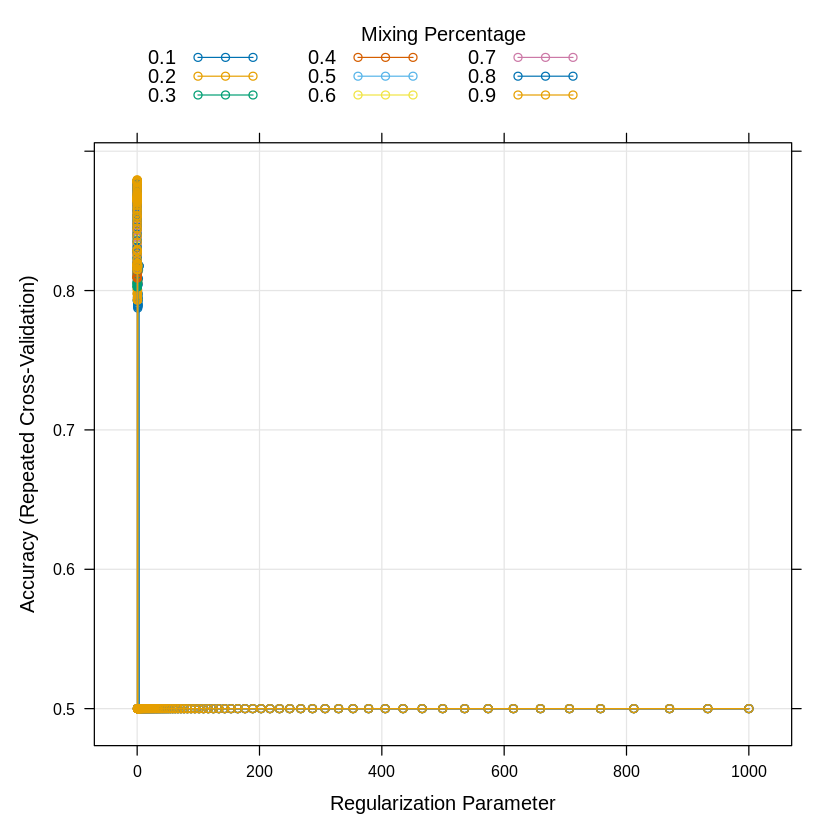

In [ ]:
#A sequence of lambdas
#install.packages("glmnet")
lambdas = 10^seq(-3, 3, length = 200)
alphas = seq(0.1,0.9,by=0.1)

set.seed(10582390)
mod.ridge.b = train(
  Classification~.,
  data = mydata.b.train,
  method = "glmnet",
  preProcess = NULL,
  trControl = trainControl("repeatedcv", number = 10, repeats = 2),
  tuneGrid = expand.grid(alpha = alphas, lambda = lambdas)
)
plot(mod.ridge.b)
mod.ridge.b$bestTune

,alpha,lambda
,<dbl>,<dbl>
51,0.1,0.03217642


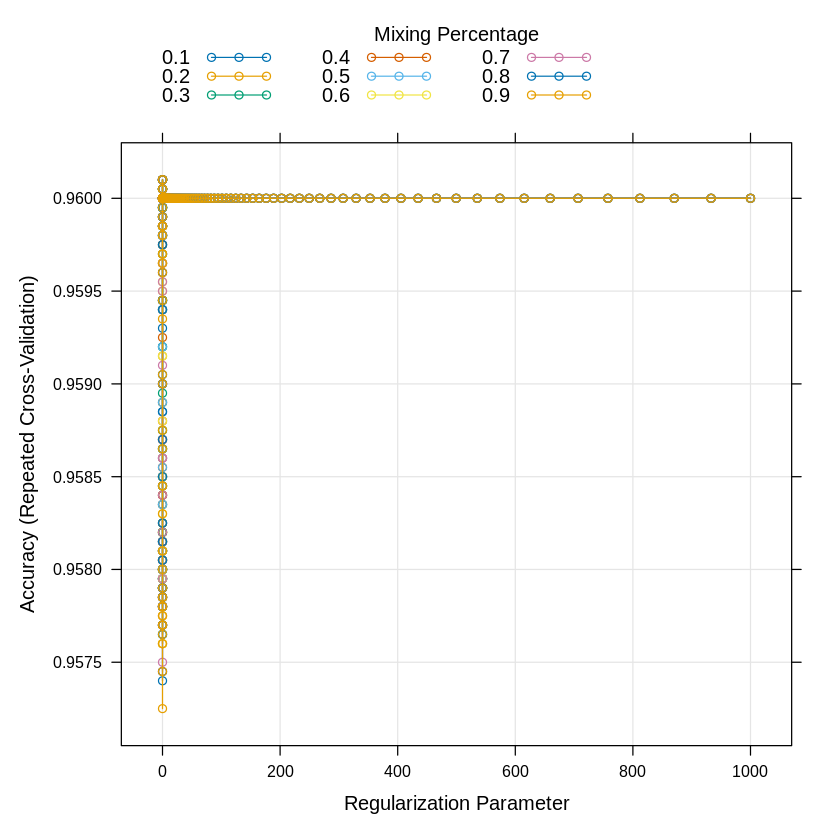

In [ ]:
set.seed(10582390)
mod.ridge.ub = train(
  Classification~.,
  data = mydata.ub.train,
  method = "glmnet",
  preProcess = NULL,
  trControl = trainControl("repeatedcv", number = 10, repeats = 2),
  tuneGrid = expand.grid(alpha = alphas, lambda = lambdas)
)
plot(mod.ridge.ub)
mod.ridge.ub$bestTune

In [ ]:
coef(mod.ridge.b$finalModel, mod.ridge.b$bestTune$lambda)
coef(mod.ridge.ub$finalModel, mod.ridge.ub$bestTune$lambda)

18 x 1 sparse Matrix of class "dgCMatrix"
                                                   s1
(Intercept)                      -16.9929797340020450
AlertCategoryInformational        -0.1686157797775745
AlertCategoryWarning               0.3228153879381522
NetworkEventTypePolicyViolation    0.2735971011847944
NetworkEventTypeThreatDetected    -0.1235332388609571
NetworkInteractionTypeCritical     1.6688148549592485
NetworkInteractionTypeElevated    -0.7735092029396784
NetworkInteractionTypeOthers       6.8854245171157098
NetworkInteractionTypeSuspicious  -0.7920960123131332
DataTransferVolume_IN              0.0000000628911897
DataTransferVolume_OUT             0.0000001856579754
TransactionsPerSession            -0.0006090452329123
NetworkAccessFrequency            -0.0000081689117900
UserActivityLevel                  0.7825392650601120
SessionIntegrityCheckTRUE          0.0986287994389562
ResourceUtilizationFlagTRUE       -0.9927440254230818
SecurityRiskLevel                  0.000

18 x 1 sparse Matrix of class "dgCMatrix"
                                                s1
(Intercept)                       2.30239699306262
AlertCategoryInformational        .               
AlertCategoryWarning              .               
NetworkEventTypePolicyViolation   .               
NetworkEventTypeThreatDetected   -0.04659962552638
NetworkInteractionTypeCritical    0.52003505280924
NetworkInteractionTypeElevated    .               
NetworkInteractionTypeOthers      0.45576489637785
NetworkInteractionTypeSuspicious -0.21234798038237
DataTransferVolume_IN            -0.00000001382787
DataTransferVolume_OUT            0.00000001797562
TransactionsPerSession            0.00003759483024
NetworkAccessFrequency            .               
UserActivityLevel                -0.12066389528888
SessionIntegrityCheckTRUE         .               
ResourceUtilizationFlagTRUE      -0.32644534304904
SecurityRiskLevel                 .               
ResponseTime                      .     

In [ ]:
pred.class.b = predict(mod.ridge.b,new=mydata.test)
pred.class.ub = predict(mod.ridge.ub,new=mydata.test)

cf.b = table(relevel(pred.class.b, ref="Malicious"),
             relevel(mydata.test$Classification, ref="Malicious"))
cf.ub = table(relevel(pred.class.ub, ref="Malicious"),
             relevel(mydata.test$Classification, ref="Malicious"))

prop.b = round(prop.table(cf.b, 2), digits = 3);prop.b
prop.ub = round(prop.table(cf.ub, 2), digits = 3);prop.ub

           
            Malicious Normal
  Malicious     0.888  0.135
  Normal        0.112  0.865

           
            Malicious Normal
  Malicious         0      0
  Normal            1      1

In [ ]:
confusionMatrix(cf.b,mode="everything")
confusionMatrix(cf.ub,mode="everything")

Confusion Matrix and Statistics

           
            Malicious Normal
  Malicious     17257  62713
  Normal         2167 402548
                                             
               Accuracy : 0.8661             
                 95% CI : (0.8652, 0.8671)   
    No Information Rate : 0.9599             
    P-Value [Acc > NIR] : 1                  
                                             
                  Kappa : 0.3022             
                                             
 Mcnemar's Test P-Value : <0.0000000000000002
                                             
            Sensitivity : 0.88844            
            Specificity : 0.86521            
         Pos Pred Value : 0.21579            
         Neg Pred Value : 0.99465            
              Precision : 0.21579            
                 Recall : 0.88844            
                     F1 : 0.34724            
             Prevalence : 0.04008            
         Detection Rate : 0.03560       

Confusion Matrix and Statistics

           
            Malicious Normal
  Malicious         5      7
  Normal        19419 465254
                                             
               Accuracy : 0.9599             
                 95% CI : (0.9594, 0.9605)   
    No Information Rate : 0.9599             
    P-Value [Acc > NIR] : 0.5078             
                                             
                  Kappa : 0.0005             
                                             
 Mcnemar's Test P-Value : <0.0000000000000002
                                             
            Sensitivity : 0.00025741         
            Specificity : 0.99998495         
         Pos Pred Value : 0.41666667         
         Neg Pred Value : 0.95993381         
              Precision : 0.41666667         
                 Recall : 0.00025741         
                     F1 : 0.00051451         
             Prevalence : 0.04007551         
         Detection Rate : 0.00001032    

## ------------------------------------------------------------------
#                   Part 2 – RANDOM FOREST
## ------------------------------------------------------------------

In [ ]:
mod.rf.b = ranger(
  Classification~.,
  data = mydata.b.train,
  num.trees = 500,
  mtry = 3,
  respect.unordered.factors = TRUE,
  seed = 10582390,
  importance = "impurity"
)
mod.rf.ub = ranger(
  Classification~.,
  data = mydata.ub.train,
  num.trees = 500,
  mtry = 3,
  respect.unordered.factors = TRUE,
  seed = 10582390,
  importance = "impurity"
)

In [ ]:
mod.rf.b
mod.rf.ub

Ranger result

Call:
 ranger(Classification ~ ., data = mydata.b.train, num.trees = 500,      mtry = 3, respect.unordered.factors = TRUE, seed = 10582390,      importance = "impurity") 

Type:                             Classification 
Number of trees:                  500 
Sample size:                      19200 
Number of independent variables:  12 
Mtry:                             3 
Target node size:                 1 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error:             0.70 % 

Ranger result

Call:
 ranger(Classification ~ ., data = mydata.ub.train, num.trees = 500,      mtry = 3, respect.unordered.factors = TRUE, seed = 10582390,      importance = "impurity") 

Type:                             Classification 
Number of trees:                  500 
Sample size:                      10000 
Number of independent variables:  12 
Mtry:                             3 
Target node size:                 1 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error:             4.12 % 

In [ ]:
pred.mod.rf.b = predict(mod.rf.b, data = mydata.test);pred.mod.rf.b
pred.mod.rf.ub = predict(mod.rf.ub, data = mydata.test);pred.mod.rf.ub

Aggregating predictions.. Progress: 88%. Estimated remaining time: 4 seconds.


Ranger prediction

Type:                             Classification 
Sample size:                      484685 
Number of independent variables:  12 

Aggregating predictions.. Progress: 93%. Estimated remaining time: 2 seconds.


Ranger prediction

Type:                             Classification 
Sample size:                      484685 
Number of independent variables:  12 

In [ ]:
cm.b = confusionMatrix(
  pred.mod.rf.b$predictions,
  mydata.test$Classification,
  mode="everything");cm.b
cm.ub = confusionMatrix(
  pred.mod.rf.ub$predictions,
  mydata.test$Classification,
  mode="everything");cm.ub

Confusion Matrix and Statistics

           Reference
Prediction  Malicious Normal
  Malicious      2610   6227
  Normal        16814 459034
                                             
               Accuracy : 0.9525             
                 95% CI : (0.9519, 0.9531)   
    No Information Rate : 0.9599             
    P-Value [Acc > NIR] : 1                  
                                             
                  Kappa : 0.1637             
                                             
 Mcnemar's Test P-Value : <0.0000000000000002
                                             
            Sensitivity : 0.134370           
            Specificity : 0.986616           
         Pos Pred Value : 0.295349           
         Neg Pred Value : 0.964665           
              Precision : 0.295349           
                 Recall : 0.134370           
                     F1 : 0.184707           
             Prevalence : 0.040076           
         Detection Rate : 0.005

Confusion Matrix and Statistics

           Reference
Prediction  Malicious Normal
  Malicious       402    989
  Normal        19022 464272
                                             
               Accuracy : 0.9587             
                 95% CI : (0.9581, 0.9593)   
    No Information Rate : 0.9599             
    P-Value [Acc > NIR] : 1                  
                                             
                  Kappa : 0.0334             
                                             
 Mcnemar's Test P-Value : <0.0000000000000002
                                             
            Sensitivity : 0.0206960          
            Specificity : 0.9978743          
         Pos Pred Value : 0.2890007          
         Neg Pred Value : 0.9606409          
              Precision : 0.2890007          
                 Recall : 0.0206960          
                     F1 : 0.0386260          
             Prevalence : 0.0400755          
         Detection Rate : 0.000

In [ ]:
grid.rf = expand.grid(num.trees = c(200, 300, 400, 500),
                      mtry = c(3:11),
                      min.node.size = seq(2, 10, 2),
                      replace = c(TRUE, FALSE),
                      sample.fraction = c(0.5, 0.6, 0.7, 0.8, 1),
                      OOB.misclass = NA,
                      test.sens = NA,
                      test.spec = NA,
                      test.acc = NA)
dim(grid.rf)
grid.rf

[1] 1800    9

num.trees,mtry,min.node.size,replace,sample.fraction,OOB.misclass,test.sens,test.spec,test.acc
<dbl>,<int>,<dbl>,<lgl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>
200,3,2,TRUE,0.5,NA,NA,NA,NA
300,3,2,TRUE,0.5,NA,NA,NA,NA
400,3,2,TRUE,0.5,NA,NA,NA,NA
500,3,2,TRUE,0.5,NA,NA,NA,NA
200,4,2,TRUE,0.5,NA,NA,NA,NA
300,4,2,TRUE,0.5,NA,NA,NA,NA
400,4,2,TRUE,0.5,NA,NA,NA,NA
500,4,2,TRUE,0.5,NA,NA,NA,NA
200,5,2,TRUE,0.5,NA,NA,NA,NA


In [ ]:
rf.train = function(data.train) {
  for (I in 1:nrow(grid.rf)) {
    rf = ranger(Classification ~ .,
                data = data.train,
                num.trees = grid.rf$num.trees[I],
                mtry = grid.rf$mtry[I],
                min.node.size = grid.rf$min.node.size[I],
                replace = grid.rf$replace[I],
                sample.fraction = grid.rf$sample.fraction[I],
                seed = 10582390,
                respect.unordered.factors = "order")

    grid.rf$OOB.misclass[I] = rf$prediction.error %>% round(5) * 100

    pred.test = predict(rf, data = mydata.test)$predictions

    test.cf = confusionMatrix(relevel(pred.test, ref="Malicious"),
            relevel(mydata.test$Classification, ref="Malicious"))

    prop.cf = test.cf$table %>% prop.table(2)
    grid.rf$test.sens[I] = prop.cf[1,1] %>% round(5)*100      #Sensitivity
    grid.rf$test.spec[I] = prop.cf[2,2] %>% round(5)*100      #Specificity
    grid.rf$test.acc[I] = test.cf$overall[1] %>% round(5)*100 #Accuracy
  }
  return(grid.rf[order(grid.rf$OOB.misclass, decreasing = FALSE)[1:10],])
}

In [ ]:
rf.train(mydata.b.train)

In [ ]:
rf.train(mydata.ub.train)